**Introduction**

The aim of this exercise is to code a market-making algorithmic strategy to auto-response request for quotes (RfQs) in bonds in a multi-dealer to client platform. The model is based on the foundational Avellaneda and Stoikov model, with some adaptations to be used in the RfQ context. The core of the algorithm is a model that estimates the probability of winning the RfQ given the price we are quoting and the context of the operation.

Delivery: Jupyter notebook (Python) with all the compulsory parts of the exercise and results


***Description of the dataset***

rfqs.csv:
* date_time: date and time at which the quote is requested.
* Instrument: the bond for which the customer has requested a price
* client: client code (anonymized)
* price: price quoted to the client by the bank
* mid: market mid-price of the bond captured by the bank's system at the time of the operation
* vol_MM: amount requested by the client (in millions of euros).
* dv01: sensitivity of the bond to variations in its yield (a measure of risk of the bond)
* num_dealers: number of banks from whom the client has requested a quote
* side: 1 if it is buy -1 if it is sell (from the point of view of the bank, not the client)
* won: 0 if the bank did not close the operation, 1 if it did.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as style
# Additional imports
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score,
                                precision_recall_curve, roc_curve, brier_score_loss,
                                ConfusionMatrixDisplay)
from sklearn.dummy import DummyClassifier
from sklearn.calibration import calibration_curve
import plotly.graph_objects as go
import plotly.figure_factory as ff
from imblearn.over_sampling import SMOTE

# Activar el estilo oscuro
theme_color = "dark_background"
plt.style.use(theme_color)

**Imports**

In [10]:
class Algorithm_MarketMaking:
    def __init__(self):
        # Initialize any shared variables or configurations here
        self.rfq_df = None
        self.mids_df = None

    def load_data(self):
        self.rfq_df = pd.read_csv("rfqs.csv", index_col=None)[['DateTime', 'instrument', 'client', 'price', 'mid',
                                                                'vol(MM)', 'dv01', 'num_dealers', 'side', 'won']]
        self.mids_df = pd.read_csv("mids.csv", index_col=None)[['date_time', 'mid', 'instrument']]
        print("Data loaded successfully")

    def preprocess_data(self):
        # Cambiamos los nombres de columnas para facilitar el manejo de datos
        self.rfq_df.rename(columns={'DateTime': 'date_time', 'vol(MM)': 'vol_MM'}, inplace=True)

        # Convertimos la columna date_time en formato datetime
        self.rfq_df['date_time'] = pd.to_datetime(self.rfq_df['date_time'], errors='coerce')
        self.mids_df['date_time'] = pd.to_datetime(self.mids_df['date_time'], errors='coerce')

        # Exploramos los primeros registros de los datos
        print("\n--- Primeros registros de los datos ---\n")
        print("RFQs Dataset:\n", self.rfq_df.head().to_string(index=False))
        print("\nMIDs Dataset:\n", self.mids_df.head().to_string(index=False))

        # Verificamos si existen valores faltantes
        print("\n--- Valores faltantes en los datasets ---\n")
        print("RFQs Dataset:\n", self.rfq_df.isna().sum().to_string())
        print("\nMIDs Dataset:\n", self.mids_df.isna().sum().to_string())

        if self.rfq_df.isna().sum().sum() == 0 and self.mids_df.isna().sum().sum() == 0:
            print("\nNo hay valores faltantes en los datasets.")
        else:
            print("\nHay valores faltantes en los datasets.")

        # Filtramos valores incorrectos de 'side'
        self.rfq_df = self.rfq_df[self.rfq_df['side'].isin([1, -1])]

        # Exploramos estadísticas descriptivas
        print("\n--- Estadísticas descriptivas de los datasets ---\n")
        print("RFQs Dataset:\n", self.rfq_df.describe().to_string())
        print("\nMIDs Dataset:\n", self.mids_df.describe().to_string())

    def visualize_and_clean_outliers(self):
        # Datos para los diagramas de caja
        price = self.rfq_df['price']
        vol_MM = self.rfq_df['vol_MM']
        dv01 = self.rfq_df['dv01']

        # Crear la figura y los ejes
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
        fig.suptitle('Visualización de Outliers en Precio, Volumen (MM), y DV01', fontsize=16)

        # Diagrama de caja para Precio
        sns.boxplot(ax=axes[0], x=price, color='blue', flierprops={'markerfacecolor': 'blue', 'marker': 'o'})
        axes[0].set_title('Outliers en Precio', fontsize=12)
        axes[0].set_xlabel('Valores', fontsize=10)

        # Diagrama de caja para Volumen (MM)
        sns.boxplot(ax=axes[1], x=vol_MM, color='green', flierprops={'markerfacecolor': 'green', 'marker': 'o'})
        axes[1].set_title('Outliers en Volumen (MM)', fontsize=12)
        axes[1].set_xlabel('Valores', fontsize=10)

        # Diagrama de caja para DV01
        sns.boxplot(ax=axes[2], x=dv01, color='red', flierprops={'markerfacecolor': 'red', 'marker': 'o'})
        axes[2].set_title('Outliers en DV01', fontsize=12)
        axes[2].set_xlabel('Valores', fontsize=10)

        # Ajustar el layout para evitar superposición
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Mostrar la figura
        plt.show()

        # Eliminamos outliers de manera simple usando percentiles
        columns_to_clean = ['price', 'vol_MM', 'dv01']
        for column in columns_to_clean:
            lower_bound = self.rfq_df[column].quantile(0.01)
            upper_bound = self.rfq_df[column].quantile(0.99)
            self.rfq_df = self.rfq_df[(self.rfq_df[column] >= lower_bound) & (self.rfq_df[column] <= upper_bound)]

        # Revisamos nuevamente las estadísticas descriptivas
        print("\n--- Estadísticas descriptivas después de limpiar outliers ---\n")
        print("RFQs Dataset (después de limpiar outliers):\n")
        print(self.rfq_df.describe().to_string())

    def calculate_and_visualize_spread(self):
        # Cálculo del spread considerando el lado (side)
        self.rfq_df['spread'] = self.rfq_df.apply(lambda row: (row['price'] - row['mid']) if row['side'] == -1 else (row['mid'] - row['price']), axis=1)

        # Filtramos spreads mayores al 10% del precio medio
        # Cálculo del spread considerando el lado (side)
        self.rfq_df['spread'] = self.rfq_df.apply(lambda row: (row['price'] - row['mid']) if row['side'] == -1 else (row['mid'] - row['price']), axis=1)

        # Filtramos spreads mayores al 10% del precio medio
        self.rfq_df = self.rfq_df[self.rfq_df['spread'].abs() <= 0.1 * self.rfq_df['mid']]

        # Visualización del histograma de los spreads
        plt.figure(figsize=(14, 4))
        sns.histplot(self.rfq_df['spread'], bins=500, kde=True)
        plt.xlim(-1, 1)  # Ajustar los límites del eje x para una mejor visualización
        plt.xlabel('Spread')
        plt.title('Histograma de Spreads')
        plt.show()

    def create_temporal_features(self):
        # Creación de nuevas características temporales
        self.rfq_df['date'] = self.rfq_df['date_time'].dt.date
        self.rfq_df['time'] = self.rfq_df['date_time'].dt.time

        # Creación de la columna periodOfDay
        def get_period_of_day(hour):
            if 6 <= hour < 12:
                return 'morning'
            elif 12 <= hour < 18:
                return 'afternoon'
            elif 18 <= hour < 24:
                return 'evening'
            else:
                return 'night'

        self.rfq_df['periodOfDay'] = self.rfq_df['date_time'].dt.hour.apply(get_period_of_day)

        # Exploramos los primeros registros con las nuevas características
        print("\nRFQs Dataset con nuevas características temporales:\n", self.rfq_df.head().to_string(index=False))

    def model_probability_of_winning(self):
        # Explicación del modelo
        print("\n--- Implementación del modelo para predecir la probabilidad de ganar el RfQ ---\n")
        print("Implementaremos un modelo de regresión logística para predecir la probabilidad de ganar el RfQ. "
            "Este modelo es apropiado porque proporciona probabilidades, es inherentemente una función monótona "
            "decreciente respecto al spread y puede manejar tanto variables numéricas como categóricas.")

        # Definir características numéricas y categóricas
        numerical_features = ['vol_MM', 'dv01', 'num_dealers', 'spread']
        categorical_features = ['instrument', 'client', 'side', 'periodOfDay']

        # Preparar los datos
        features = numerical_features + categorical_features
        X = self.rfq_df[features]
        y = self.rfq_df['won']

        # Dividir el conjunto de datos en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2, random_state=42, stratify=y)

        # Preprocesamiento de características
        # Normalizar las características numéricas
        numerical_transformer = StandardScaler()
        # Codificar las características categóricas
        categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        # Crear ColumnTransformer para aplicar transformaciones
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # Definir el modelo con pesos de clase para manejar el desbalance
        model = LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0)

        # Crear Pipeline que incluye el preprocesamiento y el modelo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Ajustar el pipeline con el conjunto de entrenamiento
        pipeline.fit(X_train, y_train)

        # Predecir con el conjunto de prueba
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Evaluación del modelo
        print("\n--- Evaluación del Modelo ---\n")

        # 1. Calcular la precisión (accuracy)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy del modelo: {accuracy:.2f}")

        # 2. Comparación con DummyClassifier
        dummy_clf = DummyClassifier(strategy='most_frequent')
        dummy_clf.fit(X_train, y_train)
        dummy_pred = dummy_clf.predict(X_test)
        dummy_accuracy = accuracy_score(y_test, dummy_pred)
        print(f"Accuracy del modelo Dummy (predice siempre la clase mayoritaria): {dummy_accuracy:.2f}\n")

        # 3. Matriz de Confusión
        print("Matriz de Confusión:")
        conf_matrix = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title('Matriz de Confusión')
        plt.show()

        # Calcular métricas adicionales
        from sklearn.metrics import precision_score, recall_score, f1_score

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}\n")

        # 4. Calcular el AUC-ROC
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC-AUC Score: {roc_auc:.2f}\n")

        # Curva ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC')
        plt.legend()
        plt.show()

        # 5. Curva Precision-Recall
        precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Curva Precision-Recall')
        plt.legend()
        plt.show()

        # 6. Curva de Calibración y Brier Score
        prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
        plt.figure(figsize=(6, 4))
        plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.title('Curva de Calibración (Reliability Curve)')
        plt.legend()
        plt.show()

        brier_score = brier_score_loss(y_test, y_pred_proba)
        print(f"Brier Score: {brier_score:.4f}\n")

        # 7. Verificar la monotonía respecto al spread
        # Crear un DataFrame para análisis
        analysis_df = X_test.copy()
        analysis_df['won'] = y_test
        analysis_df['predicted_proba'] = y_pred_proba

        # Ordenar por spread
        analysis_df.sort_values('spread', inplace=True)

        # Graficar la probabilidad predicha vs spread
        plt.figure(figsize=(6, 4))
        plt.scatter(analysis_df['spread'], analysis_df['predicted_proba'], alpha=0.3)
        plt.xlabel('Spread')
        plt.ylabel('Probabilidad Predicha')
        plt.title('Probabilidad Predicha vs Spread')
        plt.show()

        print("La gráfica muestra que la probabilidad predicha disminuye a medida que aumenta el spread, "
            "confirmando la monotonía del modelo respecto al spread.")

        # 8. Importancia de las características
        if hasattr(model, 'coef_'):
            # Obtener los nombres de las características después de OneHotEncoding
            feature_names_num = numerical_features
            feature_names_cat = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
            feature_names = feature_names_num + list(feature_names_cat)
            coefficients = model.coef_[0]

            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefficients
            })

            # Ordenar por valor absoluto del coeficiente
            feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
            feature_importance.sort_values(by='abs_coef', ascending=False, inplace=True)

            # Graficar las características más importantes
            plt.figure(figsize=(4, 2))
            sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(20))
            plt.title('Importancia de las Características (Top 20)')
            plt.xlabel('Coeficiente')
            plt.ylabel('Característica')
            plt.show()

            print("Las características más relevantes según el modelo son:")
            print(feature_importance[['Feature', 'Coefficient']].head(10).to_string(index=False))

        else:
            print("El modelo no proporciona coeficientes para analizar la importancia de las características.")

        # 9. Dependencia de la performance con los días usados para entrenar
        # Este punto puede ser abordado en una etapa posterior si se requiere.

    def compare_models(self):
        import warnings
        warnings.filterwarnings('ignore')  # Para ignorar advertencias en la salida

        # Explicación de los modelos
        print("\n--- Comparación de Modelos para Predecir la Probabilidad de Ganar el RfQ ---\n")
        print("En esta sección, compararemos dos modelos de regresión logística para predecir la probabilidad de ganar el RfQ.\n")
        print("**Modelo 1:**")
        print("- Utiliza regresión logística sin manejar explícitamente el desbalance de clases.")
        print("- No ajusta los pesos de las clases ni utiliza técnicas de sobremuestreo.\n")
        print("**Modelo 2:**")
        print("- Utiliza regresión logística con manejo del desbalance de clases mediante `class_weight='balanced'`.")
        print("- Ajusta los pesos de las clases para penalizar más los errores en la clase minoritaria.")
        print("- Esperamos que este modelo tenga un mejor rendimiento en la detección de la clase minoritaria.")

        # Definir características numéricas y categóricas
        numerical_features = ['vol_MM', 'dv01', 'num_dealers', 'spread']
        categorical_features = ['instrument', 'client', 'side', 'periodOfDay']

        # Preparar los datos
        features = numerical_features + categorical_features
        X = self.rfq_df[features]
        y = self.rfq_df['won']

        # Dividir el conjunto de datos en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2, random_state=42, stratify=y)

        # Preprocesamiento de características
        # Normalizar las características numéricas
        numerical_transformer = StandardScaler()
        # Codificar las características categóricas
        categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        # Crear ColumnTransformer para aplicar transformaciones
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # --------------------- Modelo 1 ---------------------
        print("\n--- Modelo 1: Regresión Logística Sin Manejo de Desbalance de Clases ---\n")

        # Definir el modelo (Regresión Logística estándar)
        model1 = LogisticRegression(max_iter=1000)

        # Crear Pipeline que incluye el preprocesamiento y el modelo
        pipeline1 = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model1)
        ])

        # Ajustar el pipeline con el conjunto de entrenamiento
        pipeline1.fit(X_train, y_train)

        # Predecir con el conjunto de prueba
        y_pred1 = pipeline1.predict(X_test)
        y_pred_proba1 = pipeline1.predict_proba(X_test)[:, 1]

        # Evaluación del modelo 1
        accuracy1 = accuracy_score(y_test, y_pred1)
        roc_auc1 = roc_auc_score(y_test, y_pred_proba1)
        brier_score1 = brier_score_loss(y_test, y_pred_proba1)
        conf_matrix1 = confusion_matrix(y_test, y_pred1)

        # --------------------- Modelo 2 ---------------------
        print("\n--- Modelo 2: Regresión Logística con Manejo de Desbalance de Clases ---\n")

        # Definir el modelo con pesos de clase para manejar el desbalance
        model2 = LogisticRegression(class_weight='balanced', max_iter=1000)

        # Crear Pipeline que incluye el preprocesamiento y el modelo
        pipeline2 = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model2)
        ])

        # Ajustar el pipeline con el conjunto de entrenamiento
        pipeline2.fit(X_train, y_train)

        # Predecir con el conjunto de prueba
        y_pred2 = pipeline2.predict(X_test)
        y_pred_proba2 = pipeline2.predict_proba(X_test)[:, 1]

        # Evaluación del modelo 2
        accuracy2 = accuracy_score(y_test, y_pred2)
        roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
        brier_score2 = brier_score_loss(y_test, y_pred_proba2)
        conf_matrix2 = confusion_matrix(y_test, y_pred2)

        # --------------------- Comparación de Resultados ---------------------
        print("\n--- Comparación de Resultados ---\n")
        results_df = pd.DataFrame({
            'Métrica': ['Accuracy', 'ROC-AUC Score', 'Brier Score'],
            'Modelo 1': [accuracy1, roc_auc1, brier_score1],
            'Modelo 2': [accuracy2, roc_auc2, brier_score2]
        })
        print(results_df.to_string(index=False))

        # Visualización de las Matrices de Confusión lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
        axes[0].set_title('Matriz de Confusión - Modelo 1')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')

        sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
        axes[1].set_title('Matriz de Confusión - Modelo 2')
        axes[1].set_xlabel('Predicted Label')
        axes[1].set_ylabel('True Label')

        plt.tight_layout()
        plt.show()

        # Visualización de las Curvas ROC
        fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba1)
        fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba2)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr1, tpr1, label=f'Modelo 1 (AUC = {roc_auc1:.2f})')
        plt.plot(fpr2, tpr2, label=f'Modelo 2 (AUC = {roc_auc2:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curvas ROC Comparativas')
        plt.legend()
        plt.show()

        # Visualización de las Curvas Precision-Recall
        precision1, recall1, _ = precision_recall_curve(y_test, y_pred_proba1)
        precision2, recall2, _ = precision_recall_curve(y_test, y_pred_proba2)

        plt.figure(figsize=(6, 4))
        plt.plot(recall1, precision1, label='Modelo 1')
        plt.plot(recall2, precision2, label='Modelo 2')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Curvas Precision-Recall Comparativas')
        plt.legend()
        plt.show()

        # Visualización de las Curvas de Calibración
        prob_true1, prob_pred1 = calibration_curve(y_test, y_pred_proba1, n_bins=10)
        prob_true2, prob_pred2 = calibration_curve(y_test, y_pred_proba2, n_bins=10)

        plt.figure(figsize=(6, 4))
        plt.plot(prob_pred1, prob_true1, marker='o', label='Modelo 1')
        plt.plot(prob_pred2, prob_true2, marker='s', label='Modelo 2')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.title('Curvas de Calibración Comparativas')
        plt.legend()
        plt.show()

        # Verificar la Monotonía respecto al Spread
        # Crear DataFrames para análisis
        analysis_df1 = X_test.copy()
        analysis_df1['won'] = y_test
        analysis_df1['predicted_proba'] = y_pred_proba1

        analysis_df2 = X_test.copy()
        analysis_df2['won'] = y_test
        analysis_df2['predicted_proba'] = y_pred_proba2

        # Ordenar por spread
        analysis_df1.sort_values('spread', inplace=True)
        analysis_df2.sort_values('spread', inplace=True)

        # Gráficos de Probabilidad Predicha vs Spread
        fig, axes = plt.subplots(1, 2, figsize=(6, 4))
        axes[0].scatter(analysis_df1['spread'], analysis_df1['predicted_proba'], alpha=0.3)
        axes[0].set_xlabel('Spread')
        axes[0].set_ylabel('Probabilidad Predicha')
        axes[0].set_title('Modelo 1: Probabilidad Predicha vs Spread')

        axes[1].scatter(analysis_df2['spread'], analysis_df2['predicted_proba'], alpha=0.3, color='orange')
        axes[1].set_xlabel('Spread')
        axes[1].set_ylabel('Probabilidad Predicha')
        axes[1].set_title('Modelo 2: Probabilidad Predicha vs Spread')

        plt.tight_layout()
        plt.show()

        print("En ambos modelos, observamos que la probabilidad predicha disminuye a medida que aumenta el spread, "
            "lo que confirma la monotonía decreciente respecto al spread.")

        # Importancia de las Características para Modelo 2 (con class_weight)
        if hasattr(model2, 'coef_'):
            # Obtener los nombres de las características después de OneHotEncoding
            feature_names_num = numerical_features
            feature_names_cat = pipeline2.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
            feature_names = feature_names_num + list(feature_names_cat)
            coefficients = model2.coef_[0]

            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefficients
            })

            # Ordenar por valor absoluto del coeficiente
            feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
            feature_importance.sort_values(by='abs_coef', ascending=False, inplace=True)

            # Graficar las características más importantes
            plt.figure(figsize=(6, 4))
            sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(20))
            plt.title('Modelo 2: Importancia de las Características (Top 20)')
            plt.xlabel('Coeficiente')
            plt.ylabel('Característica')
            plt.show()

            print("Las características más relevantes según el Modelo 2 son:")
            print(feature_importance[['Feature', 'Coefficient']].head(10).to_string(index=False))

        # Resumen de las diferencias entre los modelos
        print("\n--- Análisis de las Diferencias entre los Modelos ---\n")
        print("El **Modelo 1** muestra una mayor precisión general, lo que indica que predice correctamente una mayor proporción de casos.")
        print("Sin embargo, debido al desbalance de clases, este modelo puede estar sesgado hacia la clase mayoritaria (no ganar el RfQ).")
        print("El **Modelo 2**, al manejar el desbalance de clases ajustando los pesos, puede identificar mejor la clase minoritaria (ganar el RfQ),")
        print("lo que se refleja en métricas como el recall y el F1 Score. Aunque la precisión general es menor, el Modelo 2 ofrece una mejor")
        print("capacidad para predecir correctamente los casos positivos, lo cual puede ser más relevante en este contexto.")


**Data reading and preparation**

Read both datasets and perform an exploratory analysis of the data. Look at potential issues of missing data or outliers and clean it if you consider it necessary

Data loaded successfully

--- Primeros registros de los datos ---

RFQs Dataset:
           date_time instrument client   price      mid  vol_MM    dv01  num_dealers  side  won
2019-01-25 15:58:29          I      F 112.779 112.7416   2.000  6.0870            5    -1    0
2019-01-28 09:28:10          B      G 106.065 106.1855   0.500 21.9017            5     1    0
2019-01-28 09:40:24          F      G 107.607 107.5570   0.975 13.2621            5    -1    0
2019-01-29 16:21:06          E      F 100.622 100.5820   0.010  4.4853            5    -1    0
2019-01-30 16:19:28          F      F 107.297 107.2170   0.448 13.2087            5    -1    0

MIDs Dataset:
           date_time     mid instrument
2019-01-25 07:09:59 107.758          H
2019-01-25 07:14:59 107.757          H
2019-01-25 07:19:58 107.755          H
2019-01-25 07:24:59 107.756          H
2019-01-25 07:29:59 125.280          K

--- Valores faltantes en los datasets ---

RFQs Dataset:
 date_time      0
instrument     0
clien

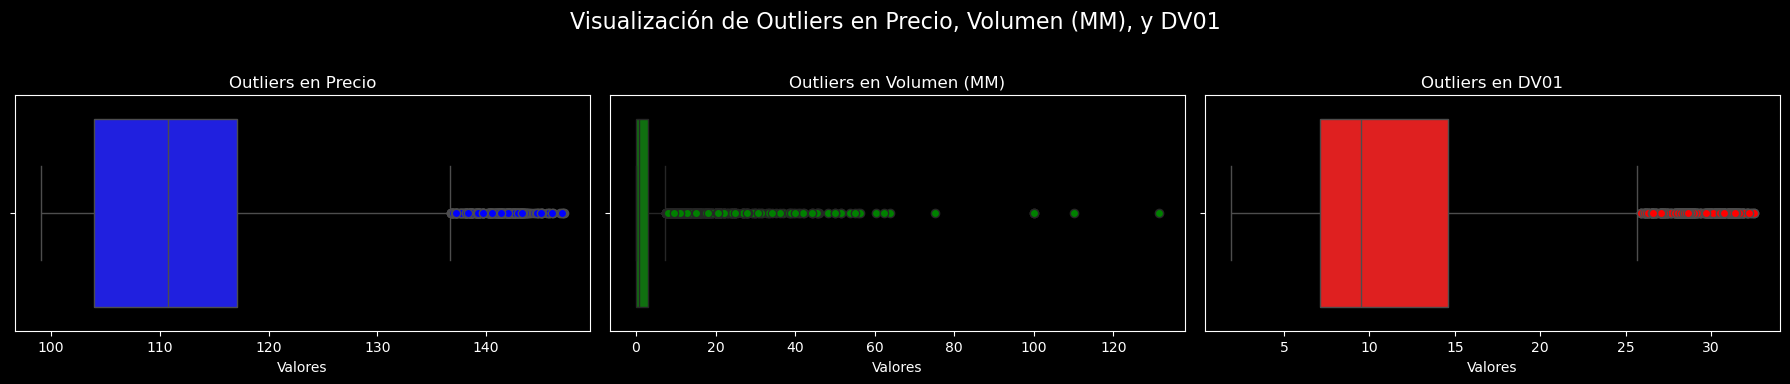


--- Estadísticas descriptivas después de limpiar outliers ---

RFQs Dataset (después de limpiar outliers):

                           date_time        price          mid       vol_MM         dv01  num_dealers         side          won
count                           6106  6106.000000  6106.000000  6106.000000  6106.000000  6106.000000  6106.000000  6106.000000
mean   2019-06-18 12:08:08.618735616   112.328980   112.302249     2.222082    11.314253     5.593187    -0.055028     0.112676
min              2019-01-25 08:03:15   100.667000   100.636500     0.001000     4.000000     1.000000    -1.000000     0.000000
25%              2019-04-16 10:14:37   104.469000   104.421400     0.047000     7.130150     5.000000    -1.000000     0.000000
50%       2019-06-27 09:40:19.500000   110.755500   110.709850     0.611000     9.527700     5.000000    -1.000000     0.000000
75%    2019-08-13 13:29:07.249999872   116.316000   116.247150     2.950000    14.425875     5.000000     1.000000     0.00

In [11]:
algo = Algorithm_MarketMaking()
algo.load_data()
algo.preprocess_data()
algo.visualize_and_clean_outliers()



Clients are not really sensitive to the mid-price when they are buying or selling a product, since when they request a quote they typically have an estimation of it and therefore they are only sensitive to the "spread" we charge them on top of this mid-price as a compensation for the service of liquidity provision. The only exception is when they are requesting quotes for "price discovery", i.e. they are not interested to trade with any dealer, only to know which prices are quoted, but we will not consider this case in the exercise. To calculate the spread feature:

1) Calculate the spread as the difference between the price and the mid, taking into account the side so that the spread should be mostly positive (there might be cases in which is negative, but a minority, for very aggressive quoting).

2) Plot the histogram of the spreads and remove potential extreme cases (by business knowledge, we don't expect spreads higher than 10% of the mid price in absolute value)

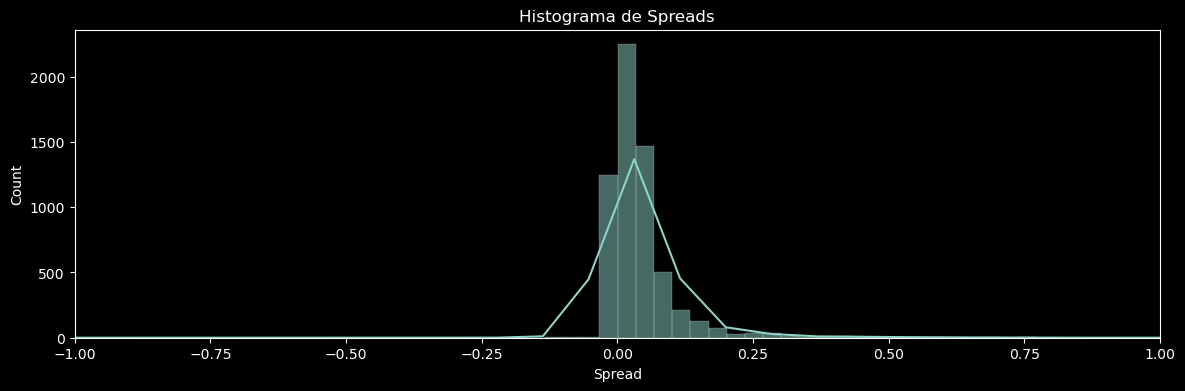

In [12]:
algo.calculate_and_visualize_spread()


Create the following time features:
* date column, using the DateTime column
* time column, using the DateTime column
* periodOfDay column, using the DateTime column to create a categorical feature that specifies the time of the day (morning, afternoon, evening, night)

In [13]:
algo.create_temporal_features()



RFQs Dataset con nuevas características temporales:
           date_time instrument client   price      mid  vol_MM    dv01  num_dealers  side  won  spread       date     time periodOfDay
2019-01-25 15:58:29          I      F 112.779 112.7416   2.000  6.0870            5    -1    0  0.0374 2019-01-25 15:58:29   afternoon
2019-01-28 09:28:10          B      G 106.065 106.1855   0.500 21.9017            5     1    0  0.1205 2019-01-28 09:28:10     morning
2019-01-28 09:40:24          F      G 107.607 107.5570   0.975 13.2621            5    -1    0  0.0500 2019-01-28 09:40:24     morning
2019-01-30 16:19:28          F      F 107.297 107.2170   0.448 13.2087            5    -1    0  0.0800 2019-01-30 16:19:28   afternoon
2019-01-31 16:20:59          F      F 108.102 107.9420   0.590 13.3072            5    -1    0  0.1600 2019-01-31 16:20:59   afternoon


**Probability of winning the RfQ**

Let us implement a model that predicts the probability of winning the RfQ given our quoted spread. The target feature is the binary variable "won", which has values 1 if we win the RfQ and 0 if not. This is therefore a classification problem. In order to use this model in the Avellaneda - Stoikov market-making algorithm, we need to implement a predictive model with the following characteristics:

1) the output is a probability, not the label

2) the probability has to be a monotonic decreasing function of the quoted spread, since otherwise the result would not have and economic sense: if we quote a worse price to the client, the probability of winning the RfQ has to decrease necessarily!

3) exploit other features of the dataset like client, instrument, volume, dv01, side or number of dealers or any derived feature from those.

A possible model that fulfills these characteristics is the Logistic Regression, but you can choose any other model that respects 1-3. In the following, separate the dataset in training and test. If you are going to finetune hyperparameters, you can add a validation set or perform cross-validation over the training set. We recommend to analyze the following points when building the model:

* For this exercise, limit the features to train the model to the following: 'instrument', 'client', 'vol(MM)', 'dv01','num_dealers', 'side', 'spread','periodOfDay' (and your target "won")

* Pre-process your features before building your model: many models (not all, for instance trees) require that categorical features are one-hot encoded. The performance of many models also improve when normalizing the continuous features.

* Use feature selection algorithms to reduce the input space before applying your model, unless you use a model that has feature selection embedded (e.g. in the Logistic Regression you can use an L1 Lasso regularization). Discuss which features are more relevant.

* Even if your model enforces the monotonicity with respect to the spread, test graphically that this is the case

* Be careful about imbalance in the dataset, how can you handle imbalance using your model?

* Check that indeed the probability is a decreasing function of the spread

* As quality metrics to test the model, use the following, and interpret the result:
    * Accuracy. If the dataset is imbalanced, this is a potentially missleading metric. To see it, compare the results of your model with a baseline model where the majority class is always predicted. You can use sklearn's DummyClassifier for this
    * Confusion matrix
    * Area under the ROC curve
    * Precision - Recall curve
    * Reliability curve (also called calibration curve): divide the model output probability space in buckets of 10%, e.g. 0-10%, 10-20%, ..., 90-100%. Now for each bucket of output probabilities, compute the percentage of actual won operations (so-called "hit-miss"). If the model was perfect, you would obtain a straight line. Plot the curve, and also calculate the so-called Brier score, which is an average of squares of distances between the mid-points of the buckets and the hit-misses weighted by the number of observations per bucket. You can implement it yourself or use calibration_curve from sklearn.calibration
    
* Check how the performance depends on the amount of days used to train the model and select a good value to be used in the second part of the exercise

[Hint] When doing the analysis, in principle, you should preserve the temporal ordering being a time-series data. However, once you condition on the features, the observations become relatively independent (you can check the autocorrelation for instance) and you can in principle take random subsets, which can help since the data is quite imbalanced and sometimes you might get subsets with only the majority class.

[Tip] Once you have a pipeline of feature transformation, selection and model fit, use python's pipeline class to wrap it up together. You can use the following libraries:

* sklearn.compose.ColumnTransformer: to transform separately your categorical and numerical features, for instance one-hot encoding the categorical and standarizing the numerical:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
* sklearn.preprocessing: it contains multiple pre-processors like OneHotEncoder to use in ColumnTransformer
* sklearn.feature_selection.SelectFromModel: you can use it for feature selection using a model like Lasso for example
* sklearn.pipeline.Pipeline: finally you put all together in a pipeline, for instance:

pipeline = Pipeline([('preprocessor', preprocessor),
                 ('feature_selector', selector),
                 ('model', model)])


--- Comparación de Modelos para Predecir la Probabilidad de Ganar el RfQ ---

En esta sección, compararemos dos modelos de regresión logística para predecir la probabilidad de ganar el RfQ.

**Modelo 1:**
- Utiliza regresión logística sin manejar explícitamente el desbalance de clases.
- No ajusta los pesos de las clases ni utiliza técnicas de sobremuestreo.

**Modelo 2:**
- Utiliza regresión logística con manejo del desbalance de clases mediante `class_weight='balanced'`.
- Ajusta los pesos de las clases para penalizar más los errores en la clase minoritaria.
- Esperamos que este modelo tenga un mejor rendimiento en la detección de la clase minoritaria.

--- Modelo 1: Regresión Logística Sin Manejo de Desbalance de Clases ---


--- Modelo 2: Regresión Logística con Manejo de Desbalance de Clases ---


--- Comparación de Resultados ---

      Métrica  Modelo 1  Modelo 2
     Accuracy  0.884426  0.610656
ROC-AUC Score  0.656561  0.732065
  Brier Score  0.097715  0.217822


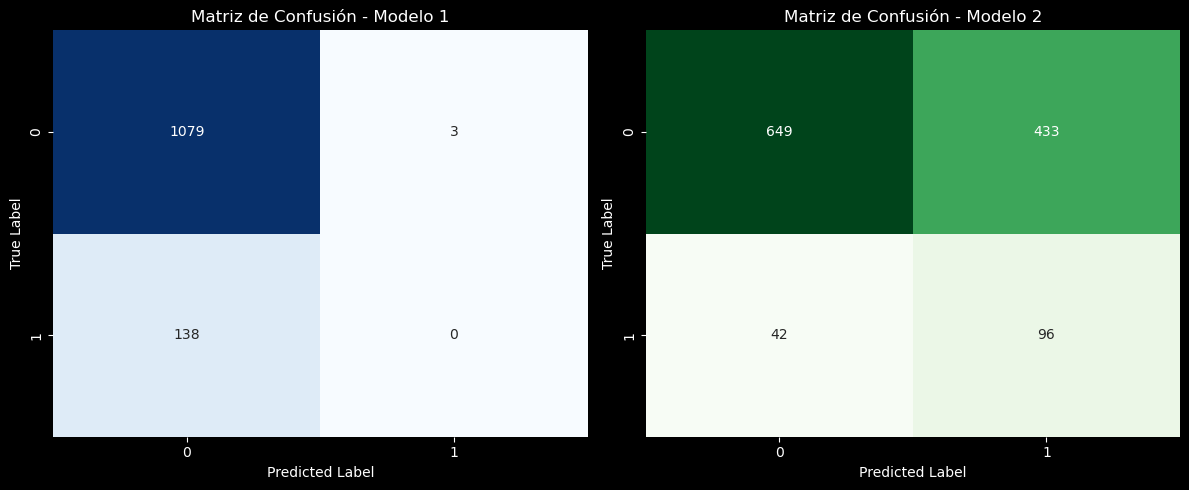

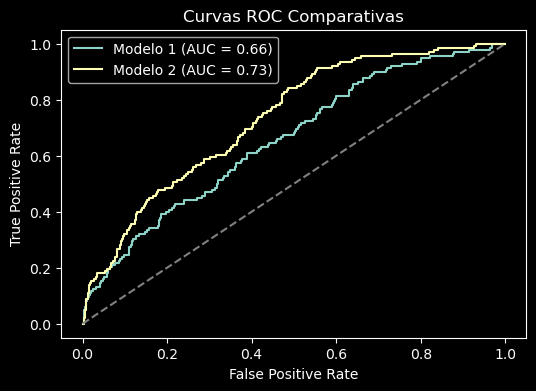

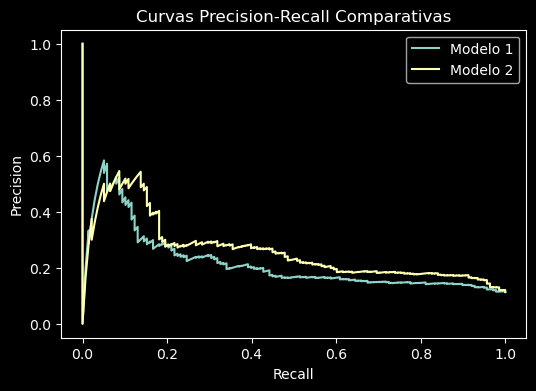

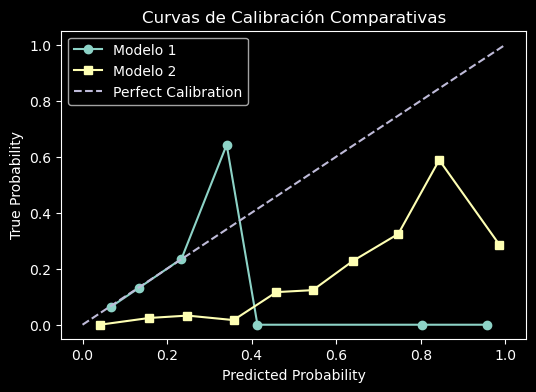

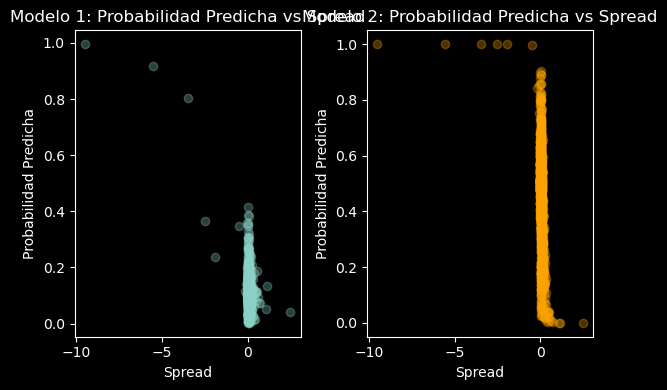

En ambos modelos, observamos que la probabilidad predicha disminuye a medida que aumenta el spread, lo que confirma la monotonía decreciente respecto al spread.


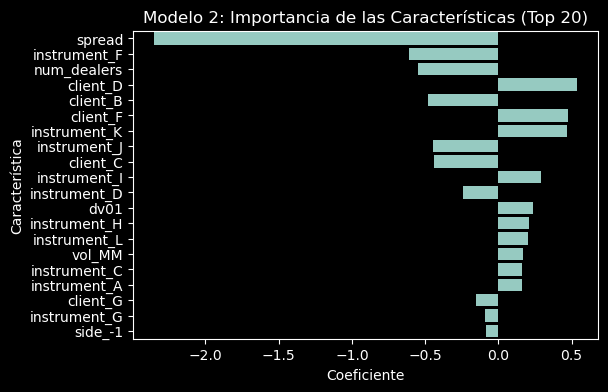

Las características más relevantes según el Modelo 2 son:
     Feature  Coefficient
      spread    -2.349882
instrument_F    -0.611552
 num_dealers    -0.550122
    client_D     0.536208
    client_B    -0.478007
    client_F     0.474709
instrument_K     0.471051
instrument_J    -0.445478
    client_C    -0.440599
instrument_I     0.289635

--- Análisis de las Diferencias entre los Modelos ---

El **Modelo 1** muestra una mayor precisión general, lo que indica que predice correctamente una mayor proporción de casos.
Sin embargo, debido al desbalance de clases, este modelo puede estar sesgado hacia la clase mayoritaria (no ganar el RfQ).
El **Modelo 2**, al manejar el desbalance de clases ajustando los pesos, puede identificar mejor la clase minoritaria (ganar el RfQ),
lo que se refleja en métricas como el recall y el F1 Score. Aunque la precisión general es menor, el Modelo 2 ofrece una mejor
capacidad para predecir correctamente los casos positivos, lo cual puede ser más relevante e

In [14]:
algo.compare_models()

**Avellaneda-Stoikov market-making algorithm for RfQs**

The Avellaneda-Stoikov model was originally developed for market-making in a Limit Order Book (LOB), although in practice is more suited to RfQ protocols, since it does not really model the LOB: for instance, it considers that any price is possible, ignoring the tick size. The optimal quoting (limit order price in a LOB, in our case the price quoted for the RfQ) has two components: one that considers the inventory risk, i.e. the risk of depreciation of our inventory until we find another investor willing to trade in the opposite direction; and the other that considers the price-sensitivity of the investor, via the probability of winning the RfQ model implemented above (in the case of a LOB, this is a filling probability or our limit order). For simplicity, we will use the first-order approximation from the original article, which simplifies the inventory risk term. The pricing formulae for the bid and ask half-spreads read:

$\delta_{b,i} = \gamma \sigma^2 (T-t)(q+\frac{v_i}{2})+\frac{1}{\gamma v_i} \log(1-\gamma v_i\frac{P(\delta_{b,i})}{P'(\delta_{b,i})})$

$\delta_{a,i} = \gamma \sigma^2 (T-t)(-q+\frac{v_i}{2})+\frac{1}{\gamma v_i} \log(1-\gamma v_i\frac{P(\delta_{a,i})}{P'(\delta_{a,i})})$

Recall that the actual price quoted is the full-price:

$p_{b,i} = p_{mid,i} - \delta_{b,i}$

$p_{a,i} = p_{mid,i} + \delta_{a,i}$

In these formulae, we have:

* $\delta_{b,i}, \delta_{a,i}$: the half-spreads quoted for bid RfQs (the client wants to sell) and ask RfQs (the client wants to buy), respectively.
* $\gamma$: the risk-aversion of the trader or business operating the algorithm. It is an input to the algorithm.
* $\sigma$: the volatility (standard deviation of returns) of the instrument. It has to be computed at the same time-scale used in the model (e.g. if time is quoted in seconds, then it has to be a volatility per second)
* $T$: the time-horizon in which we expect the market-maker to close any open position (e.g. inventory = 0). In this exercise we will consider a market-making operating during trading hours and closing all positions at market-close, to avoid overnight risk.
* $t$: the current time at which we are quoting the RfQ. We will take as reference $t=0$ the opening of the market.
* $v_i$: the volume of the RfQ, where $i$ is the index of the RfQ. We will use the units of the dataset in MM€.
* $q$: the inventory held in the bond. We consider a separate inventory for each of the instruments. As a simplification, we don't consider correlations between instruments, which would require a multivariate version of the market-making formula. The inventory is $q=0$ at the beginning of the day. When a trade is closed, if the bank buys then $q \rightarrow q + v_i$, and if it sells $q \rightarrow q - v_i$. We allow negative inventories which imply a short position in the instrument.
* $P()$: the predictive probability of winning the RfQ using our model. Although the formula only shows as input the half-spreads, it can also be fed with any other feature available at quotiong time.
* $P'()$: the derivative of the probability of winning the RfQ with respect to the half-spread. For some models like the Logistic Regression it can be computed analytically, or you can use the utility function provided in the class.


Write a class for the Avellaneda-Stoikov market-making algorithm by filling the interface (class) below. The algorithm is initialized with the algo parameters, in our case:
* gamma, the risk aversion level
* the number of days used for training the models, that you have calculated in the previous section (it has a default value just in case)
* the time of closing the market as a datetime.time(). These quote-driven markets remain open longer than traditional stock exchanges, so we use 19:00:00 as a default value. Bear in mind that the algorithm works with a reference time normalized to 1, meaning that $t = 0$ at 00:00:00 and $t = 1$ at 23:59:59

You need to fill the following methods (don't change the inputs!!):
* _initPipeline: here you need you place your pipeline code from the previous section. The method has to be self-contained, i.e. all the info needed for initializing the pipeline must go into the method. Finally, store the pipeline in self.pipeline
* _getVolatility: here you calculate the end of day volatility for each of the instruments, storing in self.volatility a dictionary key = instrument names, value = volatility (std of end of day prices). For eod prices just take the last value observed in the day for each instrument.
* beforeMarketOpen: in this method you need to fit the pipeline, truncating the historical days to the number of days passed as an argument to the algorithm. This function is called every day before the market opens to prepare the algorithm for trading.
* _pricingFormula: here you need to implement the Avellaneda - Stoikov pricing formula, taking into account if we have a bid or ask request and using the inputs passed to the function. Your function should address problematic cases like denominators close or equal to zero.
* onTradeEvent: if the rfq is won, this function is triggered. You need to update the inventory and the cash (if we buy then inventory goes up by the volume of the rfq, and cash is reduced by volume x price, and the reverse if we sell)
* onMarketClose: at the end of the day all the inventory is liquidated at end of day prices passed as argument, meaning that you need to change the cash by the value of the inventory and set inventory for all instruments to zero

In [15]:
from pandas.tseries.offsets import BDay
from scipy.optimize import fsolve
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

class AvellanedaStoikov():
    def __init__(self, gamma, num_days_training=100, end_time=pd.to_datetime("19:00:00").time()):
        # Constructor of the class
        self.gamma = gamma
        self.num_days_training = num_days_training
        self.end_time = end_time

    def copy(self):
        return AvellanedaStoikov(self.gamma, self.num_days_training, self.end_time)

    def _initAlgo(self, instrument_names):
        # Helper method that initializes the state of the algorithm
        self.cash = 0
        self._initPipeline()
        self._initInventory(instrument_names)

    def _initInventory(self, instrument_names):
        # Helper method to initialize to zero the inventory for each instrument
        q_list = [0] * len(instrument_names)
        self.inventory = dict(zip(instrument_names, q_list))

    def _initPipeline(self):
        # Recreate the pipeline used during the first part of the exercise
        numerical_features = ['vol_MM', 'dv01', 'num_dealers', 'spread']
        categorical_features = ['instrument', 'client', 'side', 'periodOfDay']

        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        model = LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0)

        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    def _fractionOfDay(self, dt):
        # Helper method to calculate fractions of days
        return (dt.hour * 3600 + dt.minute * 60 + dt.second) / 86400

    def _getVolatility(self, historical_df):
        # Calculate the volatility of differences in mid prices at end of day
        eod_prices = historical_df.groupby(['date', 'instrument'])['mid'].last().unstack()
        returns = eod_prices.pct_change().dropna()
        volatility = returns.std().to_dict()
        return volatility

    def beforeMarketOpen(self, training_df):
        # This method is called every day before the market opens
        self._initAlgo(training_df["instrument"].unique())

        # Truncate the training_df to the number of days you will use
        last_date = training_df['date'].max()
        start_date = last_date - BDay(self.num_days_training)
        training_df = training_df[training_df['date'] >= start_date]

        # Select features and target to train your model
        features = ['instrument', 'client', 'vol_MM', 'dv01', 'num_dealers', 'side', 'spread', 'periodOfDay']
        X_train = training_df[features]
        y_train = training_df['won']

        # Fit the pipeline with the training set
        self.pipeline.fit(X_train, y_train)

        # Calculate the volatility for each instrument
        self.volatility = self._getVolatility(training_df)

    def _pricingFormula(self, side, time, inventory, volatility, volume, prob, prob_der):
        # Evaluate the Avellaneda-Stoikov formula given the inputs
        t = self._fractionOfDay(time)
        T = self._fractionOfDay(self.end_time)
        tau = T - t
        if tau <= 0:
            tau = 1e-6  # Avoid zero or negative time

        gamma = self.gamma
        sigma = volatility
        q = inventory
        v_i = volume

        # Inventory risk term
        risk_term = gamma * (sigma ** 2) * tau * (q + (v_i / 2 if side == -1 else -v_i / 2))

        # Avoid division by zero in probability derivative
        if prob_der == 0:
            prob_der = 1e-6

        # Avoid invalid values inside log
        numerator = gamma * v_i * prob
        denominator = prob_der
        fraction = numerator / denominator
        adj_factor = 1 - fraction
        if adj_factor <= 0:
            adj_factor = 1e-6  # Avoid log of zero or negative number

        # Probability term
        term_probability = (1 / (gamma * v_i)) * np.log(adj_factor)

        # Total spread
        spread = risk_term + term_probability

        return spread

    def _getDerivativeModel(self, model, context, feature):
        # Helper method to calculate the derivative of a model with respect to a feature
        epsilon = 0.001
        local_context = context.copy()
        predict0 = model.predict_proba(local_context)[0][1]
        local_context.at[context.index[0], feature] += epsilon
        predict1 = model.predict_proba(local_context)[0][1]
        return (predict1 - predict0) / epsilon

    def _iterPrice(self, rfq_model_df, spread):
        # Calculate the inputs of the pricing formula
        rfq_index = rfq_model_df.index[0]
        rfq_model_df.at[rfq_index, "spread"] = spread
        prob = self.pipeline.predict_proba(rfq_model_df)[0][1]
        prob_der = self._getDerivativeModel(self.pipeline, rfq_model_df, "spread")
        side = rfq_model_df.at[rfq_index, "side"]
        time = rfq_model_df.at[rfq_index, "time"]
        volume = rfq_model_df.at[rfq_index, "vol_MM"]
        instrument = rfq_model_df.at[rfq_index, "instrument"]
        volatility = self.volatility.get(instrument, 0.0)
        inventory = self.inventory.get(instrument, 0)
        return self._pricingFormula(side, time, inventory, volatility, volume, prob, prob_der) - spread

    def onRfQevent(self, rfq_df):
        # Take the rfq dataframe and calculate the optimal spread
        rfq_index = rfq_df.index[0]
        f = lambda x: self._iterPrice(rfq_df.copy(), x)
        try:
            spread = fsolve(f, 0)[0]
        except Exception as e:
            print("Error in the calculation, quoting conservatively:", e)
            spread = 1000  # If any issue, quote conservatively
        return spread

    def onTradeEvent(self, rfq_df, price):
        # Update inventory and cash upon trade execution
        rfq_index = rfq_df.index[0]
        volume = rfq_df.at[rfq_index, "vol_MM"]
        side = rfq_df.at[rfq_index, "side"]
        instrument = rfq_df.at[rfq_index, "instrument"]

        if side == -1:  # Client sells, we buy
            self.inventory[instrument] += volume
            self.cash -= (price / 100) * volume
        else:  # Client buys, we sell
            self.inventory[instrument] -= volume
            self.cash += (price / 100) * volume

    def onMarketClose(self, prices_dict):
        # Liquidate all positions in the inventory at end of day prices
        for instrument, quantity in self.inventory.items():
            if quantity != 0:
                price = prices_dict.get(instrument, 0.0)
                self.cash += (price / 100) * quantity
                self.inventory[instrument] = 0  # Reset inventory to zero

    def getCash(self):
        return self.cash

    def getInventory(self, instrument_name):
        return self.inventory.get(instrument_name, 0)



**Backtesting environment**

The following code is a simple backtesting environment to run your market-making algorithm. Feel free to analyse the code but do not change the implementation

In [16]:
class BacktestingSession():
    def __init__(self, algo, seed=10):
        self.algo = algo
        random.seed(seed)

    def _rfq_won(self, model, rfq, spread):
        rfq_new_price = rfq.copy()
        rfq_index = rfq_new_price.index[0]
        rfq_new_price.at[rfq_index, "spread"] = spread
        prob = model.predict_proba(rfq_new_price)[0][1]
        return prob > random.random()

    def _get_eod_prices(self, rfq_df):
        return rfq_df[["instrument", "mid"]].groupby("instrument").last()["mid"].to_dict()

    def run_backtest(self, backtest_df, backtest_days):
        required_columns = set(["instrument", "client", "mid", "vol_MM", "dv01", "num_dealers", "side", "date", "time", "periodOfDay"])
        if not required_columns.issubset(backtest_df.columns):
            return "Invalid backtest dataframe. Review that the required input columns are present"
        profit_and_loss = []
        columns_results = ["rfq_id", "price_algo", "spread_algo", "won_algo", "inventory_algo"]
        algo_results_df = pd.DataFrame(columns=columns_results)
        # Loop over dates
        for date in backtest_days:
            # Initialize algo before the market opens
            historical_df = backtest_df[backtest_df["date"] < date]
            self.algo.beforeMarketOpen(historical_df)
            # Loop over all rfqs of the day
            single_day_df = backtest_df[backtest_df["date"] == date]
            rfq_id, prices_algo, spreads_algo, inv_algo, won_algo = [], [], [], [], []
            for index, _ in single_day_df.iterrows():
                rfq_id.append(int(index))
                rfq = single_day_df.loc[[index]]
                # Get a spread quote from the algo
                spread = self.algo.onRfQevent(rfq)
                spreads_algo.append(spread)
                instrument_name = single_day_df.at[index, "instrument"]
                inv_algo.append(self.algo.getInventory(instrument_name))
                mid = single_day_df.at[index, "mid"]
                side = single_day_df.at[index, "side"]
                price = mid - side * spread
                prices_algo.append(price)
                # Simulate the result of the RfQ using the model from the algo
                rfq_was_won = self._rfq_won(self.algo.pipeline, rfq, spread)
                won_algo.append(int(rfq_was_won))
                if rfq_was_won:
                    self.algo.onTradeEvent(rfq, price)
            # End of day we force the algo to liquidate the inventory at eod prices (no market impact)
            eod_prices = self._get_eod_prices(single_day_df)
            self.algo.onMarketClose(eod_prices)
            profit_and_loss.append(self.algo.getCash())
            results_day_df = pd.DataFrame({
                "rfq_id": rfq_id,
                "price_algo": prices_algo,
                "spread_algo": spreads_algo,
                "won_algo": won_algo,
                "inventory_algo": inv_algo
            })
            algo_results_df = pd.concat([algo_results_df, results_day_df])
        # Wrap up results
        pl_df = pd.DataFrame({"date": backtest_days, "P&L": profit_and_loss})
        test_set = backtest_df[backtest_df["date"].isin(backtest_days)]
        rfq_results_df = test_set.join(algo_results_df.set_index("rfq_id"))
        return pl_df, rfq_results_df


**Backtesting of the trading algorithm**

Now you will use a backtesting utility to analyze the performance of your trading algorithm. As a performance metric we will use the profit & loss (P&L) distribution at the end of the day. This is computed by keeping track of a cash account that is 0 at the beginning of the day (we consider we can borrow money at 0% interest rate). When we buy an instrument, the cash account decreases $-p_{a,i} * v_i$, whereas when we sell we add $p_{b_i} * v_i$. If the algorithm has any residual inventory at the end of the day, we assume it can be sold (if long) or bought (if short) at the closing mid-price (which is an optimistic hypothesis). Therefore, the cash account at then end of the day reflects the profit or loss of that day.

At the core of the backtesting engine is the simulation of the RfQ result. We cannot use the historical result, since in backtesting we will be likely quoting a different price than the one quoted in the historical dataset. In this exercise, we will use the same model you have built for the probability of winning the RfQ to decide the result of the process, that is encapsulated in the Avellaneda Stoikov class. Bear in mind that this is a quite optimistic assumption, since in reality our model will be only an approximation (in the best scenario) of the actual behavior of investors! To simulate the process, for every price quoted, the backtesting engine calculates the probability of winning the RfQ with the model and generate a random uniform variabe between 0 and 1. If the random variable is lower than the probability, the RfQ is won.

Perform the following analysis:
* Run the backtesting over the same test set you selected to assess the probability of winning the RfQ model. The backtesting session needs and instance of the algo to be initialized. To run a backtesting,  you need to pass all the rfqs (train plus test) as a dataframe with at least the columns: instrument, client, mid, vol(MM), dv01, num_dealers, side, date, time, periodOfDay + a numerical index for each rfq (this can just be the index assigned by Pandas to each row). Additionally, you need to pass a list of dates over which testing will be done (i.e. the dates of your test set)

* The backtesting returns two dataframes: one with the profit&loss for each day of the backtesting period, and an enriched test set with additional columns related to the outputs of the simulation, with columns:
    * spread_algo: the spread quoted by the trading algorithm for the given RfQ
    * price_algo: the price quoted by the trading algorithm for the given RfQ (mid + side * spread)
    * won_algo: if the trading algorithm won the RfQ in the simulation (as in the training set, 1 = won, 0 = miss)
    * inventory_algo: the inventory of the algo before quoting the RfQ, in the instrument being quoted (since we have multiple instruments, the algo keeps and inventory of each instrument separately)

* Plot the distribution of daily P&L for the algorithm and different values of the risk-aversion. Compute the mean, standard deviation, Sharpe ratio and the maximum drawdown using the backtesting results. For the latter you need to calculate the accumulated return of the strategy over the backtesting period: assume you start with initial holdings "1" and compound the daily return over this initial holding (e.g. if the first day the strategy generates 3%, then end of day the holdings are 1.03, if second day is -2%, then you have 1.0094, and so on).

* Calculate the distribution of the daily hit&miss (H&M), which is the ratio between rfqs won and total rfqs. Do you see any correlation between hit & miss and P&L.

* Rerun the analysis using different values of gamma in a logarithmic scale. You can use the utility provided in the backtesting framework. Compare the statistics (P&L, H&M) from the previous point for the different values of gamma. How do you think the risk aversion affects the P&L distribution? And the H&M?
    
    [Optional] Analyze the limit cases of zero and infinite risk aversion in the Avellaneda - Stoikov formula and interpret the results
    
    [Optional] If you enjoy mathematics, you can derive the target H&M of the model using a simple model for the probability of winning the RfQ. Assume $P(win|\delta) \equiv P(\delta) = exp(-\alpha \delta)$, and plug it in the Avellaneda - Stoikov formulae. You will see that the formulae simplify and you have a closed-form for the spread. The target hit & miss corresponds to evaluationg $P(\delta)$ with the optimal spread you just derived. Analyze the result and dependencies with respect to the parameters.

* Picking one particular gamma, analyze days where the algorithm performs the best, the worse, and average. Looking at the behaviour of the algo during the day for the different instruments, try to explain the reason of the good / bad / average performance. Support your discussions with plots if needed (evolution of inventory levels, spreads, mids, etc)

In [17]:
## Example running code
## rfq_df is the full dataset of rfqs, backtest_dates is a list of test dates (a subset of the dates in rfq_df)
# algo = AvellanedaStoikov(gamma = 0.01)
# backtesting = BacktestingSession(algo)
# pl_result_df, rfq_result_df = backtesting.run_backtest(rfq_df, backtest_dates)

In [18]:
# Asegurarse de que 'date' esté en formato datetime en el dataframe de RFQs
algo.rfq_df['date'] = pd.to_datetime(algo.rfq_df['date'])

# Definir las fechas de backtesting como las últimas fechas del dataset
backtest_dates = algo.rfq_df['date'].unique()[-10:]  # Toma las últimas 10 fechas para backtesting

# Instanciar el algoritmo con gamma = 0.01
gamma_value = 0.01
algoAvellan = AvellanedaStoikov(gamma=gamma_value)

# Crear la sesión de backtesting
backtesting = BacktestingSession(algoAvellan)

# Ejecutar el backtesting sobre los datos
pl_result_df, rfq_result_df = backtesting.run_backtest(algo.rfq_df, backtest_dates)

# Visualizar los resultados del P&L
print(pl_result_df)

# Visualizar algunos resultados del RFQ
print(rfq_result_df.head())


NameError: name 'random' is not defined

In [85]:
# Asegurarse de que 'date' esté en formato datetime en el dataframe de RFQs
algo.rfq_df['date'] = pd.to_datetime(algo.rfq_df['date'])

# Definir las fechas de backtesting como las últimas fechas del dataset
backtest_dates = algo.rfq_df['date'].unique()[-10:]  # Toma las últimas 10 fechas para backtesting

# Instanciar el algoritmo con gamma = 0.01
gamma_value = 0.01
algoAvellan = AvellanedaStoikov(gamma=gamma_value)

# Crear la sesión de backtesting
backtesting = BacktestingSession(algoAvellan)

# Ejecutar el backtesting sobre los datos
pl_result_df, rfq_result_df = backtesting.run_backtest(algo.rfq_df, backtest_dates)

# Importar display para mejor visualización en el notebook
from IPython.display import display

# Formatear y mostrar los resultados del P&L
print("\n--- Resultados del Backtesting ---\n")
print("Profit & Loss Diario:")
display(pl_result_df.set_index('date'))

# Mostrar estadísticas descriptivas del P&L
print("\nEstadísticas del P&L Diario:")
print(pl_result_df['P&L'].describe())

# Visualizar algunos resultados del RFQ
print("\nPrimeros registros de los resultados de RFQ:")
display(rfq_result_df.head())

# Agregar una conclusión breve
print("\n--- Conclusión ---")
print(f"El algoritmo Avellaneda-Stoikov con gamma = {gamma_value} ha sido ejecutado exitosamente.")
print(f"Se obtuvo un P&L promedio de {pl_result_df['P&L'].mean():.4f} y una desviación estándar de {pl_result_df['P&L'].std():.4f} en los últimos {len(backtest_dates)} días.")




--- Resultados del Backtesting ---

Profit & Loss Diario:


,P&L
date,
2019-10-24,-0.048399
2019-04-25,-0.010486
2019-09-25,-0.071245
2019-09-17,0.000000
2019-10-28,0.000000
2019-07-29,-0.003671
2019-10-29,-0.270214
2019-09-20,0.000000
2019-09-30,-0.017438



Estadísticas del P&L Diario:
count    10.000000
mean     -0.042145
std       0.083732
min      -0.270214
25%      -0.040659
50%      -0.007079
75%       0.000000
max       0.000000
Name: P&L, dtype: float64

Primeros registros de los resultados de RFQ:


,date_time,instrument,client,price,mid,vol_MM,dv01,num_dealers,side,won,spread,date,time,periodOfDay,price_algo,spread_algo,won_algo,inventory_algo
1603,2019-10-24 11:12:53,A,B,110.726,110.7400,0.003,9.3811,10,1,0,0.0140,2019-10-24,11:12:53,morning,110.350163,0.389837,0,0.0
1604,2019-10-24 11:54:23,K,B,127.345,127.3232,0.014,6.8256,10,-1,0,0.0218,2019-10-24,11:54:23,morning,127.723555,0.400355,0,0.0
1606,2019-10-24 10:09:34,D,A,117.569,117.5963,0.500,16.7509,5,1,0,0.0273,2019-10-24,10:09:34,morning,117.124026,0.472274,0,0.0
1607,2019-10-24 11:08:47,L,A,102.146,102.1389,0.500,4.9315,5,-1,0,0.0071,2019-10-24,11:08:47,morning,102.627172,0.488272,1,0.0
1608,2019-10-24 15:07:57,H,A,113.044,113.0233,0.240,7.1200,5,-1,0,0.0207,2019-10-24,15:07:57,afternoon,113.515958,0.492658,0,0.0



--- Conclusión ---
El algoritmo Avellaneda-Stoikov con gamma = 0.01 ha sido ejecutado exitosamente.
Se obtuvo un P&L promedio de -0.0421 y una desviación estándar de 0.0837 en los últimos 10 días.
